In [123]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import math
import sys
import re

### Question 1
calculate the maximum likelihood for each gene. Both the linear and non-linear method are demostrated here (`y_func and nll` are for non-linear method and `y_sin_func` and `test_nll`) are for non-linear method

In [124]:
def read_pset5_data(datafile): # the method to read .tbl file used in moriarty.py
    with open(datafile) as f:
        # First header line gives us the time points
        fields = f.readline().split()
        X = []
        for s in fields:
            match = re.search(r'^(\d+)hr', s)
            X.append(int(match.group(1)))
        X = np.array(X)
        N = len(X)

        # Second header line gives us "gene" followed by +=SD's
        fields = f.readline().split()
        S_true = np.zeros(N)
        for i,s in enumerate(fields[1:]):
            match = re.search(r'^\+-(\d+)', s)
            S_true[i] = float(match.group(1))

        # Third header line is just ------ stuff
        f.readline()

        # Remaining lines are data
        genenames = []
        Y = []
        for line in f.readlines():
            fields = line.split()
            genenames.append(fields[0])
            Y.append( np.array( [ float(s) for s in fields[1:]] ))
        G = len(Y)
    return genenames, X, Y, G, S_true

#### linear method for log-likelihood

use the following function:  
$y_t = p_0 + p_1 * \sin(2\pi * \omega *(t)) + p_2 * \cos(2\pi * \omega * (t))$  
where  
$p_1 = a * \cos(2\pi * \omega * \phi)$  
and  
$p_2 = a * \sin(2\pi * \omega * \phi)$

In [125]:
def y_func(t, para):
    p0 = para[0]
    p1 = para[1]
    p2 = para[2]

    y_t = p0 + p1 * np.sin(2. * math.pi * t / 24) + p2 * np.cos(2. * math.pi * t / 24)
    return y_t

In [126]:
def nll(p, D): # define the null function for the scipy.minization()
    X, S_true, Y_sub = D
    ll = 0.
    S = len(X)
    for s in range(S):
        x = X[s]
        sigma = S_true[s]
        curr_y = y_func(x, p)
        y = Y_sub[s]
        residual = y - curr_y
        ll      += stats.norm.logpdf(residual, loc=0, scale=sigma)    
    return -ll

#### None-linsear method for log_likelihood

use maximum likelihood to solve for the Phi (gene express sequence) in the given table file. use functions:  
$y_t = b + A * \sin(2\pi * (t + \phi))$ 

In [127]:
def y_sin_func(t, para): #same sin function used to test the result
    b = para[0]
    a = para[1]
    phi = para[2]
    y_t = b + a*np.sin(2 * math.pi * (t + phi) / 24)
    return y_t

In [128]:
def test_ll(p, D): # define the ll function for test
    X, S_true, Y_sub = D
    ll = 0.
    S = len(X)
    for s in range(S):
        x = X[s]
        sigma = S_true[s]
        curr_y = y_sin_func(x, p)
        y = Y_sub[s]
        residual = y - curr_y
        ll      += stats.norm.logpdf(residual, loc=0, scale=sigma)    
    return -ll

initial guess to make b = `mean(Y)` , A = $(max(Y) - min(Y)) / 2$ , and $\phi$ = 0  

#### maximum likelihood on linear method

In [129]:
genenames, X, Y, G, S_true = read_pset5_data('pset5-data.tbl')
summary_1 = {}
for g in range(12):
    Y_sub = Y[g]
    Y_sub = Y[g]
    mean_y = np.average(Y_sub)
    A = (np.max(Y_sub) - np.min(Y_sub))/2
    p0 = np.array([A, mean_y, 0])
    # p0 = np.array([40, 20, 12])
    data = np.array([X, S_true, Y_sub])
    result = optimize.minimize(nll, p0, data, bounds = [(0,None),(None, None), (None, None)])
    if result.success != True:
        sys.exit("Maximum likelihood fit failed")
    b_fit     = result.x[0]
    p1_fit   = result.x[1]
    p2_fit   = result.x[2]
    phi_fit = np.arctan(p2_fit/p1_fit) / (2 * np.pi * (1/24))
    a_fit = p2_fit / np.sin(2 * np.pi * (1/24) * phi_fit)
    if a_fit < 0:                               # there's a symmetry in the solution we have to deal with.
        a_fit  = -a_fit
        phi_fit += 12
    while phi_fit < 0:  phi_fit += 24
    while phi_fit > 24: phi_fit -= 24
    summary_1[genenames[g]] = [b_fit, a_fit , phi_fit]
df = pd.DataFrame(summary_1)
df.index = ['b', 'a', 'phi']
rslt_df = df.sort_values(by = 'phi', axis = 1, ascending = False)
rslt_df.transpose()

,b,a,phi
lentil,44.489982,30.892185,23.730144
clementine,44.288970,25.270135,21.972222
grape,41.954817,27.715379,20.159637
melon,44.800176,27.890745,17.599527
tangerine,40.927152,26.241838,15.993743
anise,40.172724,17.244434,13.715486
spinach,45.430213,20.334698,11.747026
huckleberry,42.485347,22.244470,9.946390
beet,41.578048,21.380980,7.543759
kiwi,41.515041,21.208744,5.739873


#### maximum likelihood on none-linear method

In [131]:
genenames, X, Y, G, S_true = read_pset5_data('pset5-data.tbl')
summary_2 = {}
for g in range(G):
    Y_sub = Y[g]
    mean_y = np.average(Y_sub)
    A = (np.max(Y_sub) - np.min(Y_sub))/2
    # p0 = np.array([A, mean_y, 0])
    p0 = np.array([40, 20, 12])
    data = np.array([X, S_true, Y_sub])
    result = optimize.minimize(test_ll, p0, data, bounds = [(0,None),(None, None), (None, None)])
    if result.success != True:
        sys.exit("Maximum likelihood fit failed")
    b_fit     = result.x[0]
    a_fit     = result.x[1]
    phi_fit   = result.x[2] 
    if a_fit < 0:                               # there's a symmetry in the solution we have to deal with.
        a_fit  = -a_fit
        phi_fit -= 12
    while phi_fit < 0:  phi_fit += 24
    while phi_fit > 24: phi_fit -= 24
    summary_2[genenames[g]] = [b_fit, a_fit, phi_fit]
df = pd.DataFrame(summary_2)
df.index = ['b', 'a', 'phi']
rslt_df = df.sort_values(by = 'phi', axis = 1, ascending = False)
rslt_df.transpose()

,b,a,phi
lentil,44.489953,30.892238,23.730145
clementine,44.288974,25.270101,21.972216
grape,41.954828,27.715382,20.159635
melon,44.800175,27.890744,17.599526
tangerine,40.927131,26.241809,15.993742
anise,40.172683,17.244403,13.715489
spinach,45.430162,20.334605,11.747027
huckleberry,42.485317,22.244515,9.946384
beet,41.577955,21.381068,7.543742
kiwi,41.515078,21.208786,5.739893


### Question 2: 
compare my data with M's, which is the following:  

|genename    |      b|      a|      p|
|------------| ------| ------| ------|
|cauliflower |  40.60|  25.65|  23.32|
|lentil      |  38.06|  42.31|  22.39|
|clementine  |  41.89|  27.75|  21.39|
|grape       |  46.05|  21.31|  19.76|
|melon       |  44.01|  28.86|  18.22|
|anise       |  38.76|  16.61|  14.44|
|tangerine   |  39.52|  19.77|  13.42|
|spinach     |  43.27|  22.72|  11.75|
|huckleberry |  48.45|  34.77|  10.29|
|beet        |  40.63|  17.22|   7.30|
|carrot      |  44.81|  37.24|   4.81|
|kiwi        |  36.53|  21.48|   2.13|


In [132]:
def read_M_output(file_name):
    M_info = {}
    with open(file_name) as f:
        fields = f.readline().split()
        X = []
        for s in fields:
            X.append(s)
        
        f.readline() # skip the second line

        # Remaining lines are data
        genenames = []
        para = []
        for line in f.readlines():
            fields = line.split()
            genenames.append(fields[0])
            para.append( np.array( [ float(s) for s in fields[1:]] ))
    for i, name in enumerate(genenames):
        M_info[name] = para[i]
    return M_info

In [133]:
M_info = read_M_output("output.txt")

In [139]:
M_ll = []
P_ll = []
P_nl = []
for i, entry in enumerate(M_info):
    M_para = M_info[entry]
    P_para_linear = summary_1[entry]
    P_para_nonlin = summary_2[entry]
    
    i = 0
    for name in genenames:
        if name == entry:
            Y_sub = Y[i]
        i += 1
    
    test_data = [X, S_true, Y_sub]
    tempM = test_ll(M_para, test_data)
    tempP1 = test_ll(P_para_linear, test_data)
    tempP2 = test_ll(P_para_nonlin, test_data)
    P_ll.append(tempP1)
    P_nl.append(tempP2)
    M_ll.append(tempM)
M_sum = np.sum(M_ll)
P_sum1 = np.sum(P_ll)
P_sum2 = np.sum(P_nl)
print("the total log likelihood of M data is:")
print("{} for M's method".format(M_sum))
print("{} for linear method".format(P_sum1))
print("{} for non-linear method".format(P_sum2))

the total log likelihood of M data is:
556.3600791659454 for M's method
317.89201216795635 for linear method
317.8920121688244 for non-linear method


### Answer Question 2:
My fit (maximum likelihood) have more than 1.588 times larger than the linear fit method from M student. Which means the ml method fit better than linear one

### Question 3:
Plot M's data with fit and my data with fit

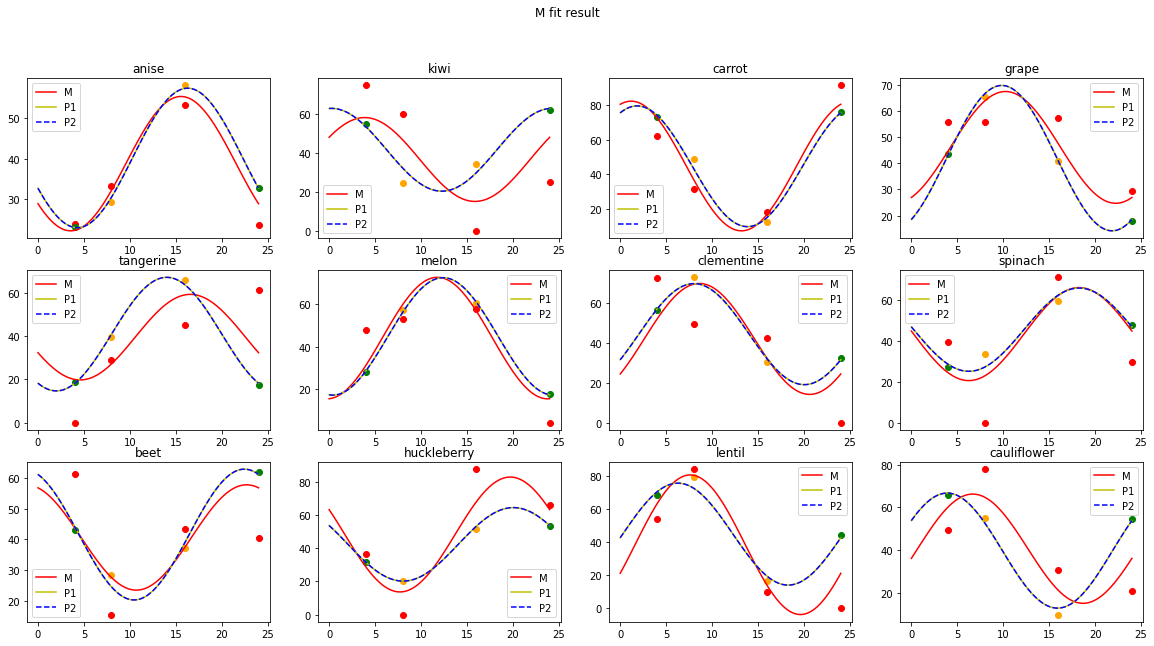

In [148]:
xx = np.linspace(0, 24, 100)
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle('M fit result')
color_s_true = {'20.0': 'r', '5.0':'orange', '2.0':'g'}
for i, entry in enumerate(M_info):
    if i >= 0 and i <4:
        j = 0
    elif i >= 4 and i < 8:
        j = 1
    else:
        j = 2
    g = i%4
    
    k = 0
    for name in genenames:
        if name == entry:
            Y_sub = Y[k]
        k += 1
        
    M_para = M_info[entry]
    P_para_1 = summary_1[entry]
    P_para_2 = summary_2[entry]
    
    axs[j,g].set_title(entry)
    for t in range(len(X)):
        axs[j,g].scatter(X[t], Y_sub[t], c=color_s_true[str(S_true[t])])
    
    
    y_t = y_sin_func(xx, M_para)
    y_t_p1 = y_sin_func(xx, P_para_1)
    y_t_p2 = y_sin_func(xx, P_para_2)
    axs[j,g].plot(xx, y_t, 'r', label='M')
    axs[j,g].plot(xx, y_t_p1, 'y',label='P1')
    axs[j,g].plot(xx, y_t_p2, '--b',label='P2')
    axs[j,g].legend()
    


The linear and none-linear method provide the same plot and it fit better with the "good" data (green and orange color dot) while M's method. M's method treat data points equally without distringuish the quality of the data. Our method follows the quality of the data point and follows the "good" data more scrictly. 